# Ajustes iniciales

## Conexión a google drive

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
%cd ./drive/MyDrive/Colab Notebooks/

[Errno 2] No such file or directory: './drive/MyDrive/Colab Notebooks/'
/content/drive/MyDrive/Colab Notebooks


In [79]:
%pwd

'/content/drive/My Drive/Colab Notebooks'

## Importar modulos *_utils


In [80]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')

from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import dataset_utils
from my_utils import results_utils
import numpy as np

# Local Utils

### getModelPredictions()

In [81]:
from pandas import DataFrame
from  tensorflow.keras.utils import to_categorical

def getModelPredictions(X_test, task, config_ID, eval_method, model_type, verbose=False):

  n_folds=7

  if model_type=='G':
    # EVALUATE THE FULL-DATASET MODEL --------------------------------------------
    if verbose:
      print('\nEvaluating full-dataset model'.format(fold_idx))

    weights_file = f'global_model_{eval_method}.hdf5'
    trained_model = loadPretrainedModel(config_ID, weights_file)

    # make predictions on X_test samples
    classes_probs = trained_model.predict(X_test)
    
    # turn the prob distributions into classes predictions 
    labels_predictions_array = getClassesPredictions(classes_probs, task)

    return labels_predictions_array
    
  elif model_type in ['E1','E2']:
    if task=='HTA':
      n_classes = 5
    else:
      n_classes = 2

    # we'll use classes_probs_sum and classes_votes_sum 
    # to generate two different ensembles 
    if task=='HTA':
      classes_probs_sum = np.zeros((len(Y_test),n_classes))
    else:
      classes_probs_sum = np.zeros((len(Y_test),1))

    classes_votes_sum = np.zeros((len(Y_test),n_classes))

    # PREDICTIONS USING FOLDS CLASSIFIERS ---------------------------------------------
    for fold_idx in range(n_folds):
      if verbose:
        print('\nEvaluating data-fold {}'.format(fold_idx))
    
      weights_file = f'F{fold_idx}_{eval_method}.hdf5'
      trained_model = loadPretrainedModel(config_ID, weights_file)

      # make predictions on X_test samples
      classes_probs = trained_model.predict(X_test)
      
      # turn the prob distributions into classes predictions 
      labels_predictions_array = getClassesPredictions(classes_probs, task)
      
      classes_probs_sum += classes_probs
      classes_votes_sum += to_categorical(labels_predictions_array, num_classes=n_classes)

    # E1
    if verbose:
      print('\nMEAN PROBABILITIES ENSEMBLE')

    if model_type == 'E1':
      print('\nMEAN PROBABILITIES ENSEMBLE')

      # turn the accumulated probabilities into classes predictions
      labels_predictions_array = getClassesPredictions(classes_probs_sum/n_folds, task)
      return labels_predictions_array
    
    #E2
    if model_type == 'E2':
      print('\nMAJORITY VOTING ENSEMBLE')

      # turn the classes votes into an array of classes predictions
      labels_predictions_array = np.array([classes_votes.argmax() for classes_votes in classes_votes_sum]).reshape(-1,1)
      return labels_predictions_array

### loadPretrainedModel()

In [82]:
#*************************     loadPretrainedModel()    ************************  
from keras.models import model_from_json

def loadPretrainedModel(config_ID, weights_file):
  # load model configuration from json file
  json_file = open(f'./models_json_files/{config_ID}.json', 'r')
  model_config = json_file.read()
  json_file.close()
  trained_model = model_from_json(model_config)

  # load pretrained weights into the model
  trained_model.load_weights(f'./trained_models/{config_ID}/{weights_file}')

  return trained_model


### getClassesPredictions()

In [86]:
import numpy as np

def class_pred(true_prob):
  if true_prob>=0.5:
    return 1
  else:
    return 0

def getClassesPredictions(classes_probs, task):
  if task=='HTA': 
    return np.array([probs.argmax() for probs in classes_probs]).reshape(-1,1)
  else:
    return np.apply_along_axis(class_pred, 1, classes_probs).reshape(-1,1)

### labels_utils

In [87]:
#**************************     getLabelsPerTask()    **************************
def getLabelsPerTask(HTA_labels):

    HS_labels = list()
    TR_labels = list()
    AG_labels = list()

    for HTA_label in HTA_labels:
        HS_label, TR_label, AG_label = mapTo3DimsFormat(HTA_label)

        HS_labels.append(HS_label)
        TR_labels.append(TR_label)
        AG_labels.append(AG_label)

    HS_labels = np.array(HS_labels).reshape(-1,1)
    TR_labels = np.array(TR_labels).reshape(-1,1)
    AG_labels = np.array(AG_labels).reshape(-1,1)

    return (HS_labels, TR_labels, AG_labels)

#**************************     mapTo3DimsFormat()    ************************** 
def mapTo3DimsFormat(AB_label):
  '''
  Maps label in five_classes_format to 3 dims labeling.

    0 -> (0,0,0)  [HT = 0, TR = 0, AG = 0]
    1 -> (1,0,0)  [HT = 1, TR = 0, AG = 0]
    2 -> (1,0,1)  [HT = 1, TR = 0, AG = 1]
    3 -> (1,1,0)  [HT = 1, TR = 1, AG = 0]
    4 -> (1,1,1)  [HT = 1, TR = 1, AG = 1]

  inpunt:
  label    - int, label in five_classes_format

  output:
  (H,T,A)  - ints tuple, labeling in 3 dims format

  '''
  if AB_label == 0:
    return(0,0,0)

  elif AB_label == 1:
    return(1,0,0)

  elif AB_label == 2:
    return(1,0,1)

  elif AB_label == 3:
    return(1,1,0)

  elif AB_label == 4:
    return(1,1,1)


## plotConfMatrix()

In [88]:
import matplotlib
import matplotlib.pyplot as plt
#labels = ["0,0,0", "1,0,0", "1,0,1", "1,1,0", "1,1,1"]

def plotConfMatrix(values, labels, title="some title"):

  fig, ax = plt.subplots(figsize=(4, 4))
  im = ax.imshow(values, cmap="Blues")

  # We want to show all ticks...
  ax.set_xticks(np.arange(len(labels)))
  ax.set_yticks(np.arange(len(labels)))
  # ... and label them with the respective list entries
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
    rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(labels)):
    for j in range(len(labels)):
      text = ax.text(j, i, values[i, j],
        ha="center", va="center", color="black")

  ax.set_title(title)
  ax.set_xlabel("Predicciones")
  ax.set_ylabel("Gold_Standard")
  fig.tight_layout()
  plt.show()

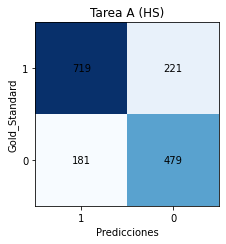

In [46]:
plotConfMatrix(cm, ['1', '0'], title="Tarea A (HS)")

# Confussion Matrix

###  Test-Dataset

In [13]:
X_test, Y_test = dataset_utils.loadEncodedTestData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return = ['HTA'])

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
1600 test instances retrieved

encodings_dim = (55, 300)


In [14]:
X_test, Y_test = dataset_utils.loadEncodedTestData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return = ['HS','TR','AG','HTA'])

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
1600 test instances retrieved

encodings_dim = (55, 300)


In [15]:
from sklearn.metrics import confusion_matrix

In [52]:
HS_pred = getModelPredictions(X_test, 'HS', 'zKWmVuqz', 'A', 'G')
HS_true = Y_test.HS.to_numpy()

cm = confusion_matrix(HS_true, HS_pred)

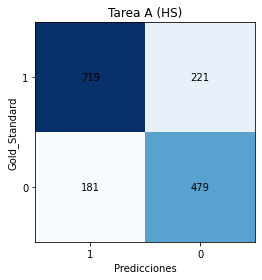

In [53]:
plotConfMatrix(cm, ['1', '0'], title="Tarea A (HS)")

In [60]:
AG_pred = getModelPredictions(X_test, 'AG', 'lYkXiQZd', 'B', 'E2')
AG_true = Y_test.AG.to_numpy()

cm = confusion_matrix(AG_true, AG_pred)


MAJORITY VOTING ENSEMBLE


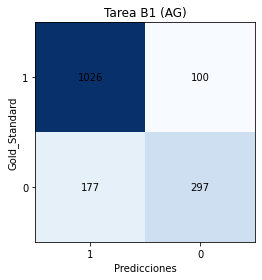

In [61]:
plotConfMatrix(cm, ['1', '0'], title="Tarea B1 (AG)")

In [56]:
TR_pred = getModelPredictions(X_test, 'TR', 'iFfHteVR', 'B', 'G')
TR_true = Y_test.TR.to_numpy()

cm=confusion_matrix(TR_true, TR_pred)

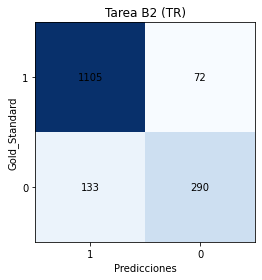

In [57]:
plotConfMatrix(cm, ['1', '0'], title="Tarea B2 (TR)")

### Tarea conjunta (NN-MIX-E1)

In [89]:
HTA_pred = getModelPredictions(X_test, 'HTA', 'OMbpCcoK', 'B', 'E1')
HTA_true = Y_test.HTA.to_numpy()

cm = confusion_matrix(HTA_true, HTA_pred)

KeyboardInterrupt: ignored

In [63]:
cm

array([[834,   1,  50,   0,  55],
       [ 83,   0,  45,   0,   6],
       [ 46,   0,  49,   0,   8],
       [ 30,   0,   4,   0,  18],
       [101,   0,   8,   0, 262]])

In [90]:
import numpy as np
cm = np.array([[834,   1,  0,   50,  55],
       [ 83,   0,  0,   45,   6],
       [ 30,   0,   0,   4,  18],
       [ 46,   0,  0,   49,   8],
       [101,   0,   0,   8, 262]])

In [75]:
cm

array([[834,   1,   0,  50,  55],
       [ 83,   0,   0,  45,   6],
       [ 30,   0,   0,   4,  18],
       [ 46,   0,   0,  49,   8],
       [101,   0,   0,   8, 262]])

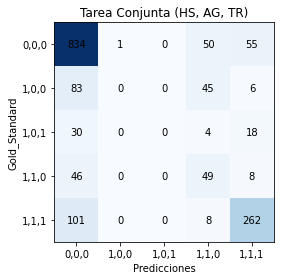

In [91]:
plotConfMatrix(cm, ['0,0,0', '1,0,0','1,0,1', '1,1,0', '1,1,1'], title="Tarea Conjunta (HS, AG, TR)")

In [ ]:
"""
0 -> (0,0,0)  [HT = 0, TR = 0, AG = 0]
1 -> (1,0,0)  [HT = 1, TR = 0, AG = 0]
2 -> (1,0,1)  [HT = 1, TR = 0, AG = 1]
3 -> (1,1,0)  [HT = 1, TR = 1, AG = 0]
4 -> (1,1,1)  [HT = 1, TR = 1, AG = 1]
"""

### Tarea conjunta (CNN-E1)

In [67]:
HTA_pred = getModelPredictions(X_test, 'HTA', 'GWVBtYHV', 'B', 'E1')
HTA_true = Y_test.HTA.to_numpy()

cm = confusion_matrix(HTA_true, HTA_pred)


MEAN PROBABILITIES ENSEMBLE


In [68]:
cm

array([[791,   4,  87,   0,  58],
       [ 62,   5,  60,   0,   7],
       [ 37,   0,  59,   0,   7],
       [ 25,   2,   5,   0,  20],
       [ 98,   0,  18,   0, 255]])

In [69]:
import numpy as np
cm = np.array([[791,   4,  87,   0,  58],
       [ 62,   5,  60,   0,   7],
       [ 25,   2,   5,   0,  20],
       [ 37,   0,  59,   0,   7],
       [ 98,   0,  18,   0, 255]])

In [70]:
cm

array([[791,   4,  87,   0,  58],
       [ 62,   5,  60,   0,   7],
       [ 25,   2,   5,   0,  20],
       [ 37,   0,  59,   0,   7],
       [ 98,   0,  18,   0, 255]])

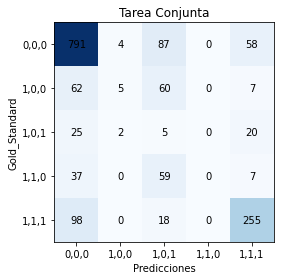

In [71]:
plotConfMatrix(cm, ['0,0,0', '1,0,0','1,0,1', '1,1,0', '1,1,1'], title="Tarea Conjunta")

In [ ]:
HS_pred, TR_pred, AG_pred = getLabelsPerTask(predictions)

HS_true, TR_true, AG_true = [Y_test['HS'], Y_test['TR'], Y_test['AG']]
HS_true = HS_true.to_numpy()
TR_true = TR_true.to_numpy()
AG_true = AG_true.to_numpy()

In [ ]:
confusion_matrix(HS_true, HS_pred)

array([[818, 122],
       [241, 419]])

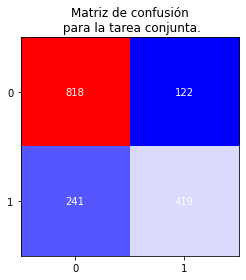

In [ ]:
plotConfMatrix(confusion_matrix(HS_true, HS_pred), ['0','1'])

In [ ]:
confusion_matrix(HS_true, HS_pred)

array([[818, 122],
       [241, 419]])

In [ ]:
confusion_matrix(TR_true, TR_pred)

array([[1105,   72],
       [ 134,  289]])

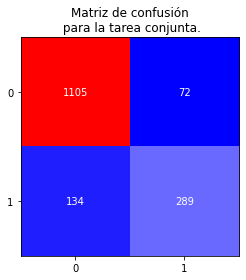

In [ ]:
plotConfMatrix(confusion_matrix(TR_true, TR_pred), ['0','1'])

In [ ]:
confusion_matrix(AG_true, AG_pred)

array([[926, 200],
       [134, 340]])

In [ ]:
predictions = getModelPredictions(X_test, 'OMbpCcoK', 'HTA', 'B', 'E2')

from sklearn.metrics import confusion_matrix
y_true = Y_test.HTA.to_numpy()
y_pred = predictions

confusion_matrix(y_true, y_pred)

array([[818,   1,  64,   0,  57],
       [ 78,   0,  49,   0,   7],
       [ 41,   0,  54,   0,   8],
       [ 29,   0,   5,   0,  18],
       [ 93,   0,   7,   0, 271]])

In [ ]:
predictions = getModelPredictions(X_test, 'YBJbUNaX', 'HTA', 'A', 'E1')

from sklearn.metrics import confusion_matrix
y_true = Y_test.HTA.to_numpy()
y_pred = predictions

cm = confusion_matrix(y_true, y_pred)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
#labels = ["0,0,0", "1,0,0", "1,0,1", "1,1,0", "1,1,1"]

def plotConfMatrix(values, labels):

  fig, ax = plt.subplots()
  im = ax.imshow(values, cmap='bwr')

  # We want to show all ticks...
  ax.set_xticks(np.arange(len(labels)))
  ax.set_yticks(np.arange(len(labels)))
  # ... and label them with the respective list entries
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(labels)):
      for j in range(len(labels)):
          text = ax.text(j, i, values[i, j],
                        ha="center", va="center", color="w")

  ax.set_title("Matriz de confusión\n para la tarea conjunta.")
  fig.tight_layout()
  plt.show()

In [ ]:
"""
0 -> (0,0,0)  [HT = 0, TR = 0, AG = 0]
1 -> (1,0,0)  [HT = 1, TR = 0, AG = 0]
2 -> (1,0,1)  [HT = 1, TR = 0, AG = 1]
3 -> (1,1,0)  [HT = 1, TR = 1, AG = 0]
4 -> (1,1,1)  [HT = 1, TR = 1, AG = 1]
"""

## evaluation

In [ ]:
merged_results = DataFrame()

config_ids = ['xCdcvedN', 'YBJbUNaX', 'WFNrfnfd', 'GWVBtYHV', 'PZKzUveQ']

for config_id in config_ids[:]:
  config_metrics_df = evaluateTrainedModels(X_train, Y_train, 'HTA', config_id, 'B', 'CNN2', 7)
  merged_results=merged_results.append(config_metrics_df, ignore_index=True)

*****

In [ ]:
merged_results.shape

(35, 11)

In [ ]:
with open('./Results/final/CNN2_HTA_VALIDATION.df', 'wb') as file_handler:
  pickle.dump(merged_results, file_handler)

In [ ]:
merged_results

,conf_id,model_type,architecture,A_acc,B1_acc,B2_acc,A1_f1,B1_f1,B2_f1,F1_multi,EMR
0,xCdcvedN,F,CNN2,0.804196,0.890909,0.816783,0.791103,0.854681,0.792634,0.812806,0.765035
1,xCdcvedN,F,CNN2,0.827972,0.900699,0.834965,0.819374,0.861610,0.812601,0.831195,0.784615
2,xCdcvedN,F,CNN2,0.816527,0.901961,0.822129,0.807205,0.867018,0.803282,0.825835,0.780112
3,xCdcvedN,F,CNN2,0.806723,0.914566,0.837535,0.790971,0.883889,0.813996,0.829619,0.771709
4,xCdcvedN,F,CNN2,0.816527,0.897759,0.810924,0.808860,0.865663,0.793206,0.822576,0.770308
5,xCdcvedN,F,CNN2,0.817927,0.903361,0.830532,0.809520,0.873478,0.812933,0.831977,0.782913
6,xCdcvedN,F,CNN2,0.824930,0.910364,0.829132,0.814798,0.877456,0.809348,0.833868,0.782913
7,YBJbUNaX,F,CNN2,0.815385,0.899301,0.827972,0.806525,0.864848,0.809982,0.827118,0.772028
8,YBJbUNaX,F,CNN2,0.819580,0.907692,0.850350,0.805243,0.876111,0.825461,0.835605,0.784615
9,YBJbUNaX,F,CNN2,0.813725,0.899160,0.817927,0.804760,0.866292,0.797253,0.822769,0.767507


In [ ]:
evaluateTrainedModels(X_train, Y_train, 'HTA', 'buWKkGpy', 'A', 'CNN1', 7)

buWKkGpy 


Evaluating data-fold 0
EMR =  0.765034965034965
F1_multi =  0.8118190853762185


Evaluating data-fold 1
EMR =  0.765034965034965
F1_multi =  0.8269660028725091


Evaluating data-fold 2
EMR =  0.7591036414565826
F1_multi =  0.8024194971785185


Evaluating data-fold 3
EMR =  0.7675070028011205
F1_multi =  0.8182651368812829


Evaluating data-fold 4
EMR =  0.7759103641456583
F1_multi =  0.8216148933234292


Evaluating data-fold 5
EMR =  0.773109243697479
F1_multi =  0.8249080067621691


Evaluating data-fold 6
EMR =  0.7787114845938375
F1_multi =  0.8271790017287962



,conf_id,model_type,architecture,A_acc,B1_acc,B2_acc,A1_f1,B1_f1,B2_f1,F1_multi,EMR
0,buWKkGpy,F,CNN1,0.805594,0.885315,0.815385,0.794519,0.846656,0.794282,0.811819,0.765035
1,buWKkGpy,F,CNN1,0.822378,0.900699,0.812587,0.814868,0.869874,0.796156,0.826966,0.765035
2,buWKkGpy,F,CNN1,0.796919,0.893557,0.806723,0.781266,0.848296,0.777697,0.802419,0.759104
3,buWKkGpy,F,CNN1,0.805322,0.904762,0.827731,0.788202,0.865432,0.801161,0.818265,0.767507
4,buWKkGpy,F,CNN1,0.823529,0.903361,0.805322,0.813701,0.868144,0.783000,0.821615,0.775910
5,buWKkGpy,F,CNN1,0.817927,0.904762,0.813725,0.808045,0.872297,0.794381,0.824908,0.773109
6,buWKkGpy,F,CNN1,0.823529,0.904762,0.826331,0.810383,0.868216,0.802938,0.827179,0.778711


# SANDBOX